In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import ast
from sklearn.svm import SVR
from sklearn.model_selection import KFold, RandomizedSearchCV, GridSearchCV, train_test_split, cross_val_score
from sklearn.inspection import permutation_importance
from bayes_opt import BayesianOptimization
from sklearn.metrics import make_scorer, mean_squared_error

In [2]:
# reading from the csv where iteration results were stored
df = pd.read_csv("./bootstrap_final.csv")

In [3]:
df.head()

,Best Model,Best Model Forward Features,Best Model Backward Features,Best Model Score
0,SVM,"(Index(['Q96NB2', 'Q96D96', 'Q01813', 'Q8NCN4'...","Index(['Q8WWH5', 'Q8NFD5', 'Q8TAE8', 'O60716',...",0.554176
1,SVM,"(Index(['Q9H3U1', 'Q8TAE8', 'Q9H477', 'Q16643'...","Index(['Q9BQE4', 'Q5VSL9', 'Q15063', 'O15269',...",0.654058
2,SVM,"(Index(['Q8WUQ7', 'Q8WVQ1', 'Q8N0Z6', 'P08559'...","Index(['Q9Y4H2', 'Q6SPF0', 'Q6P2E9', 'O15357',...",0.513088
3,SVM,"(Index(['Q8WUQ7', 'Q15063', 'Q8N1S5', 'P49006'...","Index(['Q96JP5', 'Q8WUQ7', 'O94826', 'P49006',...",0.573736
4,SVM,"(Index(['P58107', 'Q8N1S5', 'P13995', 'Q7Z7L1'...","Index(['Q14498', 'Q8N1S5', 'P09327', 'P13796',...",0.555723


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1020 entries, 0 to 1019
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Best Model                    1020 non-null   object 
 1   Best Model Forward Features   1020 non-null   object 
 2   Best Model Backward Features  1020 non-null   object 
 3   Best Model Score              1020 non-null   float64
dtypes: float64(1), object(3)
memory usage: 32.0+ KB


In [5]:
forward_list = []
# Converting string into a list
for i in df['Best Model Forward Features']:
    x = ast.literal_eval(i[7:-25])
    forward_list.append(x)
    
df['Best Model Forward Features'] = forward_list

In [6]:
backward_list = []
# Converting string into a list
for i in df['Best Model Backward Features']:
    x = ast.literal_eval(i[6:-23])
    backward_list.append(x)
    
df['Best Model Backward Features'] = backward_list

In [7]:
df.head()

,Best Model,Best Model Forward Features,Best Model Backward Features,Best Model Score
0,SVM,"[Q96NB2, Q96D96, Q01813, Q8NCN4, Q86TC9, Q96FQ...","[Q8WWH5, Q8NFD5, Q8TAE8, O60716, O14981, Q9NVC...",0.554176
1,SVM,"[Q9H3U1, Q8TAE8, Q9H477, Q16643, P14555, P1785...","[Q9BQE4, Q5VSL9, Q15063, O15269, Q9NVC6, O4383...",0.654058
2,SVM,"[Q8WUQ7, Q8WVQ1, Q8N0Z6, P08559, P19404, Q7Z7L...","[Q9Y4H2, Q6SPF0, Q6P2E9, O15357, P35221, Q8N0Z...",0.513088
3,SVM,"[Q8WUQ7, Q15063, Q8N1S5, P49006, O43837, Q9BUH...","[Q96JP5, Q8WUQ7, O94826, P49006, Q01813, P5381...",0.573736
4,SVM,"[P58107, Q8N1S5, P13995, Q7Z7L1, P13796, Q53G4...","[Q14498, Q8N1S5, P09327, P13796, Q53G44, Q9H0R...",0.555723


In [8]:
total_forward_features = []
# Appending all forward features to a single list
for i in df['Best Model Forward Features']:
    total_forward_features+=i

In [9]:
len(total_forward_features)

20400

In [10]:
total_backward_features = []
# Appending all backward features to a single list
for i in df['Best Model Backward Features']:
    total_backward_features+=i

In [11]:
# Appending all features to a single list
total_features = total_backward_features+total_forward_features

In [12]:
# Making a dictionary out of the list with distinct protein names and corresponding frequencies of them occuring in the list
frequency_dict = {item: total_features.count(item) for item in set(total_features)}

In [13]:
# Sorting the dictionary by their values (frequencies)
sorted_dict = {k: v for k, v in sorted(frequency_dict.items(), key=lambda item: item[1], reverse=True)}

In [14]:
len(sorted_dict)

417

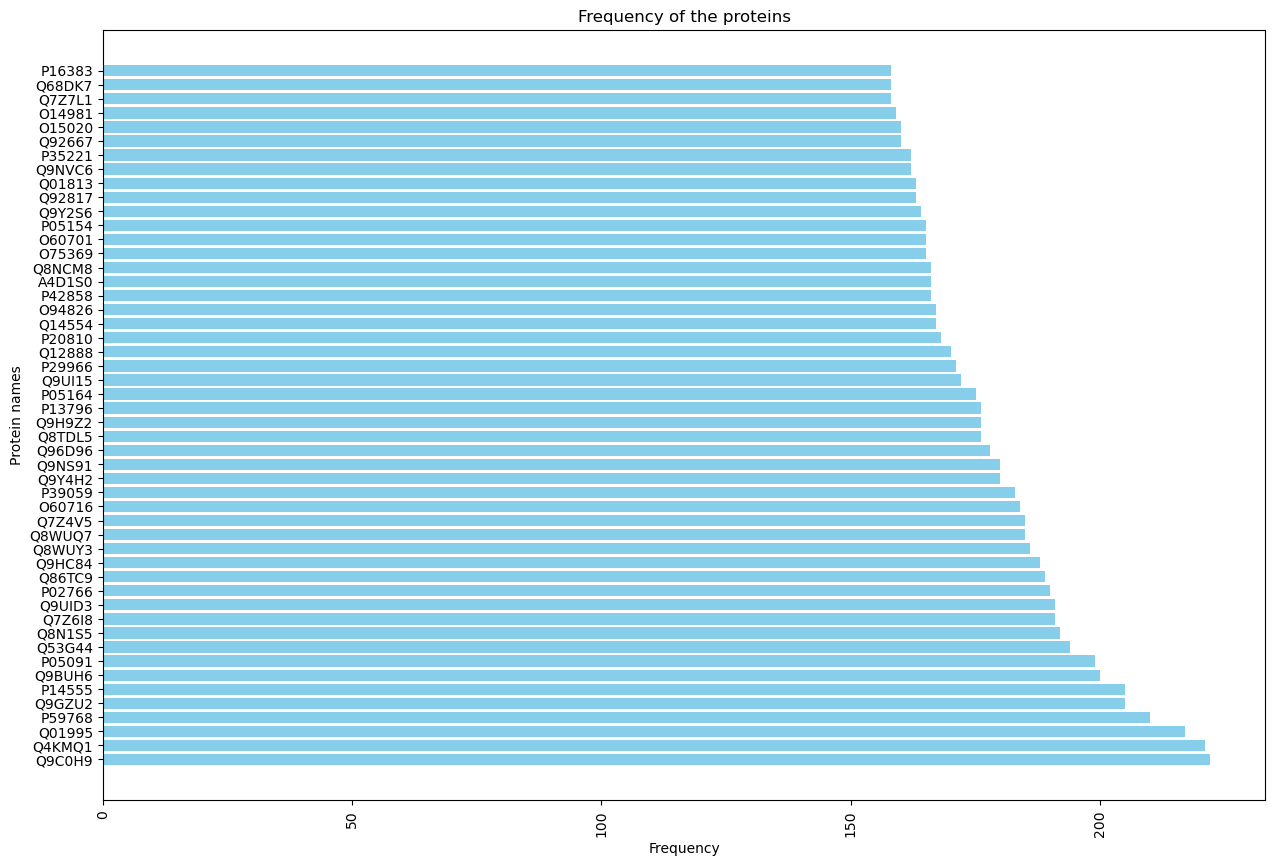

In [15]:
# Unpacking keys and values
keys, values = zip(*sorted_dict.items())

# Plotting
plt.figure(figsize=(15, 10))
plt.barh(keys[:50], values[:50], color='skyblue')
plt.ylabel('Protein names')
plt.xlabel('Frequency')
plt.title('Frequency of the proteins')
plt.xticks(rotation=90)
plt.show()


In [16]:
# Reading the Cancer Cell Line dataset to get the protein and gene names to match with our analysis data
df_ccle = pd.read_excel("Table_S2_Protein_Quant_Normalized.xlsx", sheet_name = 1)

In [17]:
prot_gene_df = df_ccle[['Gene_Symbol','Description','Uniprot','Uniprot_Acc']]

In [18]:
# Making a df which is an intersection of all the genes relevant to breast cancer and the proteins found from our iterations
df_analysis = prot_gene_df[(prot_gene_df['Uniprot_Acc'].isin(keys))] # & (prot_gene_df['Gene_Symbol'].isin(bc_gene_list))

In [19]:
# Extract common items and their values from the dictionary
df_analysis['frequency'] = df_analysis['Uniprot_Acc'].map(sorted_dict)

C:\Users\rishi\AppData\Local\Temp\ipykernel_15204\3915828576.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_analysis['frequency'] = df_analysis['Uniprot_Acc'].map(sorted_dict)


In [20]:
df_analysis.head()

,Gene_Symbol,Description,Uniprot,Uniprot_Acc,frequency
14,SRP14,SRP14_HUMAN Signal recognition particle 14 kDa...,SRP14_HUMAN,P37108,95
18,NUP133,NU133_HUMAN Nuclear pore complex protein Nup133,NU133_HUMAN,Q8WUM0,98
20,IRS2,IRS2_HUMAN Insulin receptor substrate 2,IRS2_HUMAN,Q9Y4H2,180
21,RPL4,RL4_HUMAN 60S ribosomal protein L4,RL4_HUMAN,P36578,81
33,SAMD1,SAMD1_HUMAN Atherin,SAMD1_HUMAN,Q6SPF0,103


In [21]:
print(f'Number of unique values in ID: {df_analysis["Uniprot_Acc"].nunique()}')

Number of unique values in ID: 363


In [22]:
# Sorting df by frequency
df_analysis = df_analysis.sort_values(by='frequency', ascending=False)
df_analysis.reset_index(inplace=True, drop=True)

In [23]:
df_analysis.head()

,Gene_Symbol,Description,Uniprot,Uniprot_Acc,frequency
0,TPRN,TPRN_HUMAN Taperin,TPRN_HUMAN,Q4KMQ1,221
1,TAGLN,TAGL_HUMAN Transgelin,TAGL_HUMAN,Q01995,217
2,PLA2G2A,"PA2GA_HUMAN Phospholipase A2, membrane associated",PA2GA_HUMAN,P14555,205
3,C9orf142,CI142_HUMAN Uncharacterized protein C9orf142,CI142_HUMAN,Q9BUH6,200
4,ALDH2,"ALDH2_HUMAN Aldehyde dehydrogenase, mitochondrial",ALDH2_HUMAN,P05091,199


In [24]:
df_analysis = df_analysis[df_analysis['frequency']>150]

In [25]:
gene_list = list(df_analysis['Gene_Symbol'])

In [26]:
len(gene_list)

50

In [27]:
gene_df = pd.DataFrame(gene_list)

In [ ]:
# Write the DataFrame to a CSV file
gene_df.to_csv('./final_gene.csv', index=False)

In [ ]:
df_analysis.head()